# Exploratory Data Analysis
---

**Objective:** Understand the variables, association between them and necessary transformations before model selection/building.

**Process:**
1. Importing libraries and dataset
2. Checking data types, nulls and outliers
3. Univariate analysis (target)
4. Bivariate analysis (relation to target)
5. Multivariate analysis (multicollinearity)
---

## 1. Importing libraries and dataset

In [12]:
# Adding src to the path for modules
import sys
import os
root_path = os.path.abspath('..')
src_path = os.path.join(root_path, 'src')
sys.path.append(src_path)

# Project variables and functions
import config 
import utils
import importlib
importlib.reload(utils)

# Data Manipulation
import pandas as pd
import numpy as np

# Outliers removal
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder # just to keep encoding in 1 column following the same pattern from the collected data
from sklearn.ensemble import IsolationForest

Importing the data and having a first look at it:

In [2]:
# Importing
df = utils.read_compressed_data(config.COLLECTED_DATA_PATH)

# First look
df.sample(10)

,state,age,sex,race,literate,highest_educational_level,years_studied,worker_type,work_segment,occupation_group,tax_payer,weekly_worked_hours,main_work_income,all_work_income,weekly_worked_hours_all_jobs
428116,MG,23,1,4,1,5,12,1,4,8,1,5,1400.0,1900.0,66
312221,AL,39,2,1,1,5,12,9,10,5,2,3,2600.0,2600.0,40
784843,MG,37,1,1,1,7,16,9,1,6,2,5,2400.0,2400.0,56
565301,SE,24,1,4,1,5,12,2,4,7,2,1,400.0,400.0,8
173719,MA,40,1,4,1,2,7,9,5,8,2,3,1500.0,1500.0,40
676355,MA,69,2,4,1,7,16,6,8,1,1,3,3500.0,3500.0,40
2447,BA,55,1,1,2,1,0,9,1,6,2,2,450.0,450.0,20
655447,DF,27,1,1,1,7,16,2,9,2,1,2,3000.0,3000.0,30
474811,RJ,66,2,4,1,5,12,8,10,5,1,2,2400.0,2400.0,32
447595,TO,58,2,4,1,5,12,4,11,9,2,3,1320.0,1320.0,40


---
## 2. Checking data types, nulls and outliers

Checking types:

In [3]:
# Types
df.dtypes

state                            object
age                               int64
sex                               int64
race                              int64
literate                          int64
highest_educational_level         int64
years_studied                     int64
worker_type                       int64
work_segment                      int64
occupation_group                  int64
tax_payer                         int64
weekly_worked_hours               int64
main_work_income                float64
all_work_income                 float64
weekly_worked_hours_all_jobs      int64
dtype: object

Although almost all columns are codified as numeric, most of them are truly categorical.    
The ones that are numeric should be stored in a separate variable.

In [4]:
truly_numeric = ['age', 'main_work_income', 'all_work_income', 'years_studied', 'weekly_worked_hours_all_jobs']

Checking nulls:

In [5]:
# Nulls
utils.nulls_percentage(df)

Nulls Percentage by Column: 


state                            0.00%
age                              0.00%
sex                              0.00%
race                             0.00%
literate                         0.00%
highest_educational_level        0.00%
years_studied                    0.00%
worker_type                      0.00%
work_segment                     0.00%
occupation_group                 0.00%
tax_payer                        0.00%
weekly_worked_hours              0.00%
main_work_income                 0.00%
all_work_income                  0.00%
weekly_worked_hours_all_jobs     0.00%
dtype: object

Checking outliers on the entire dataset using Isolation Forest:

In [6]:
# Creates a pipeline to pre-process the state column
transformer = ColumnTransformer(
    transformers=[
        ('state transformer', Pipeline(steps=[('ordinal encoder', OrdinalEncoder())]), ['state'])
    ],
    remainder='passthrough'
)

# Creates an instance to isolate 5% of rows
isolation_forest = Pipeline(
    steps=[
        ('transformer', transformer),
        ('model', IsolationForest(contamination=0.05, random_state=0))
    ]
)

# Trains on all columns
isolation_forest.fit(df)

# Classifies outliers based on all columns
df['outlier'] = isolation_forest.predict(df)

# Printing classification result
_, outliers = df['outlier'].value_counts()
print(f'Rows classified as outliers: {utils.make_percentage( outliers / df.shape[0])}')

Rows classified as outliers:  5.00%


Understand how classified rows differ

In [7]:
# df.columns[1:-1] excludes 'state', which is still categorical, and outliers that will be at the header row
df.groupby('outlier')[df.columns[1:-1]].mean().T

outlier,-1,1
age,51.712329,40.279288
sex,1.350602,1.423874
race,2.570307,2.538702
literate,1.526104,1.010265
highest_educational_level,3.010321,4.556604
years_studied,5.703947,11.024355
worker_type,5.891935,4.617237
work_segment,5.112219,5.396422
occupation_group,6.006343,5.632965
tax_payer,1.658083,1.370689


Isolation Forest brought interesting information about outliers averages in the data! Precisely, they have:

- much higher income
- much lower studied years
- besides being relatively older and having other smaller differences

Comparing with the original dataframe, we see that **even removing the 5% outliers, the remaining obseravations will still have nearly the same averages**:

In [8]:
# Checks entire dataset, excluding state and outlier columns
df.iloc[:, 1:-1].mean()

age                               40.850949
sex                                1.420210
race                               2.540282
literate                           1.036058
highest_educational_level          4.479288
years_studied                     10.758331
worker_type                        4.680973
work_segment                       5.382212
occupation_group                   5.651634
tax_payer                          1.385059
weekly_worked_hours                3.012140
main_work_income                2636.071503
all_work_income                 2713.003403
weekly_worked_hours_all_jobs      39.295953
dtype: float64

Dropping outliers and the newly created column

In [9]:
original_shape = df.shape
df = df.loc[df['outlier']==1].drop('outlier', axis=1)
dropped_shape = np.array(original_shape) - np.array(df.shape)
print(f'Dropped {utils.make_percentage(dropped_shape[0] / original_shape[0])} of rows and {dropped_shape[1]} column')

Dropped  5.00% of rows and 1 column


Now that outliers were looked for and removed considering all columns at once, I'll move on the variable analysis.   
There probably will be outliers on individual columns, but they will be treated later after I can visualize their interaction with the target.

----
## 3. Univariate Analysis (Target)

Checking how often the main work income corresponds to all work income: 

In [10]:
main_is_all = df.loc[df['main_work_income']==df['all_work_income']].shape[0] / df.shape[0]
print('Porportion of rows where main income represents all income:', utils.make_percentage(main_is_all))

Porportion of rows where main income represents all income:  97.13%


Checking Total Monthly Income Distribution

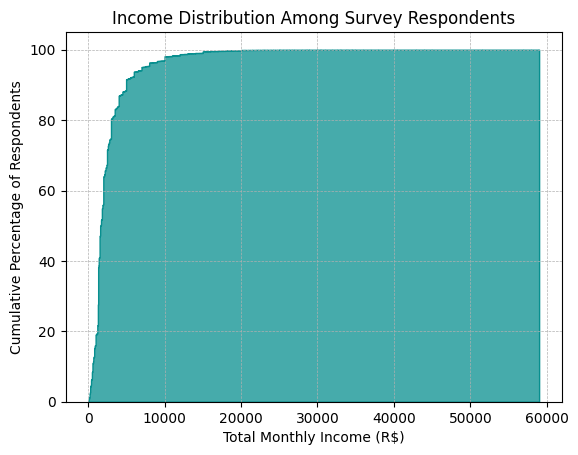

In [13]:
utils.plot_histogram(
    df['all_work_income'], 
    title= 'Income Distribution Among Survey Respondents', 
    y_label='Cumulative Percentage of Respondents', 
    x_label='Total Monthly Income (R$)',
    cumulative=True,
    element='step'
)

Even after Isolation Forest, income is highly skewed (there's but a small percentage making more than R$ 10,000).   
I'll apply winsorization to this column to take care of remaining outliers.

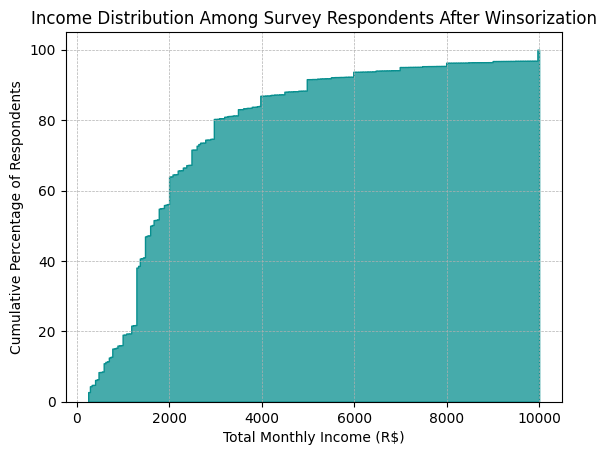

In [14]:
# Winsoring total income using 2.5% in both sides
df['all_work_income'] = utils.winsorize_columns(df[['all_work_income']], lower_percentil=0.025, upper_percentil=0.025)

# Plotting winsorized distribution
utils.plot_histogram(
    df['all_work_income'], 
    title= 'Income Distribution Among Survey Respondents After Winsorization', 
    y_label='Cumulative Percentage of Respondents', 
    x_label='Total Monthly Income (R$)',
    cumulative=True,
    element='step'
)

Much better curve!   
Checking percentage by each R$ 1000:

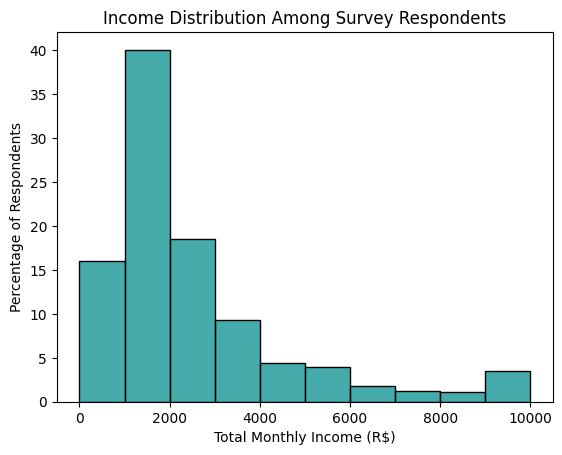

In [15]:
utils.plot_histogram(
    df['all_work_income'], 
    title= 'Income Distribution Among Survey Respondents', 
    y_label='Percentage of Respondents', 
    x_label='Total Monthly Income (R$)',
    bins = [bin for bin in range(0, 11000, 1000)]
)

Checking conformity with normality:

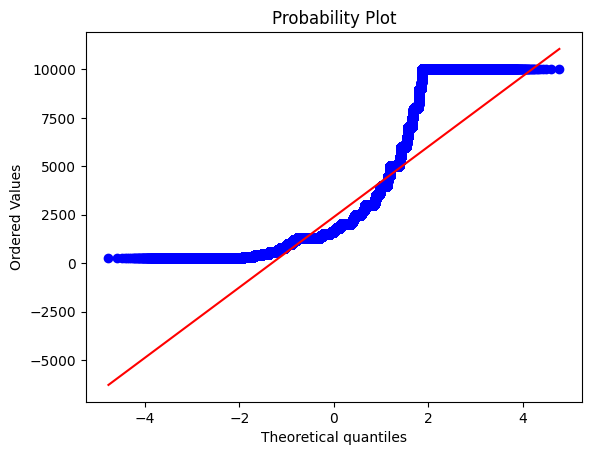

In [16]:
utils.normality_plot(df['all_work_income'])

Since income distribution is far from normality, I'll opt for non-parametric approaches for the rest of the process.   
____

## 4. Bivariate Analysis (relation to target)

Since there are over 700k observations, I'll use a sample to work with the visualizations and associations:

In [17]:
# Sampling 5%
df_sample = df.sample(frac=0.05, random_state=0)

# Comparing to previously analyzed means
df_sample[df.columns[1:]].mean()

age                               40.165399
sex                                1.423700
race                               2.524577
literate                           1.009115
highest_educational_level          4.558255
years_studied                     11.028909
worker_type                        4.622168
work_segment                       5.399136
occupation_group                   5.648957
tax_payer                          1.369512
weekly_worked_hours                3.017621
main_work_income                2422.897162
all_work_income                 2390.908318
weekly_worked_hours_all_jobs      39.456636
dtype: float64

Means are close enough!   
I'll start checking the **relationship between numeric columns**

In [18]:
# Removes all numeric columns that have the word income
truly_numeric = [col for col in truly_numeric if 'income' not in col]
print(truly_numeric)

['age', 'years_studied', 'weekly_worked_hours_all_jobs']

Plotting Regression plots:

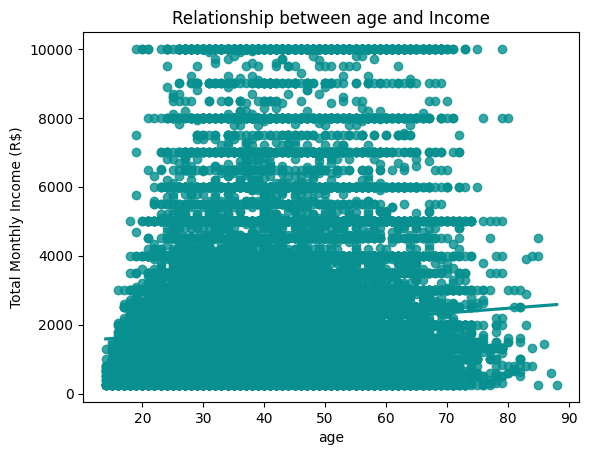

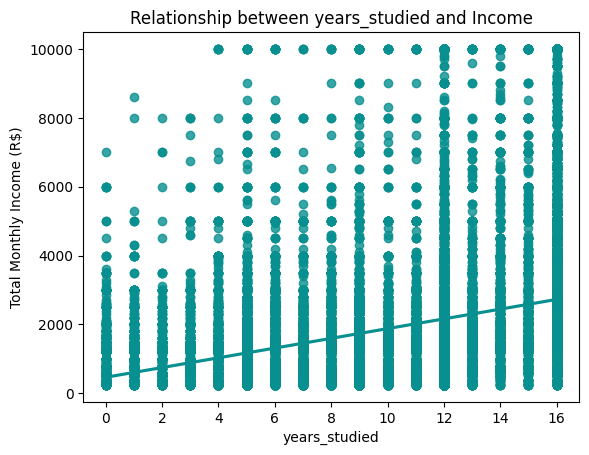

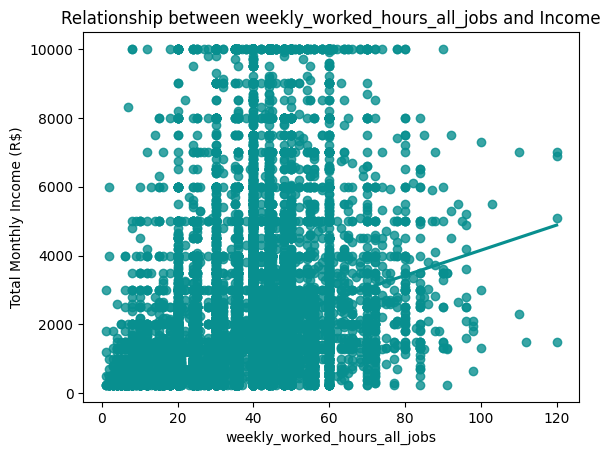

In [19]:
utils.plot_regplot(
    df = df_sample,
    numeric_columns = truly_numeric,
    target = 'all_work_income'
)

Checking spearman correlation

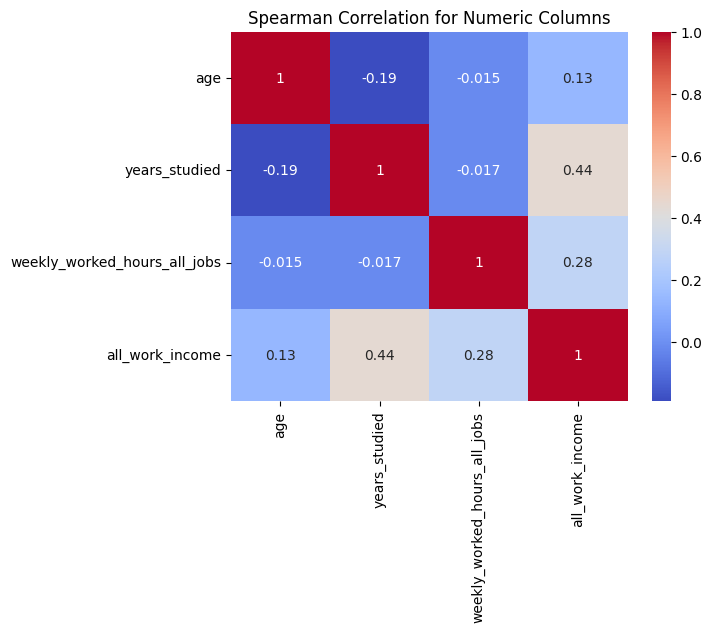

In [20]:
utils.check_spearmanr(df[truly_numeric], df['all_work_income'])

From this quick analysis, we see:
- Income is not strongly associated with age, although it tends to increase a little with time
- Income is positively associated with how many hours one works or how many years one studies, although it is a moderate association

Starting analysis for **categorical columns**

In [21]:
cat_columns = [col for col in df.columns if 'income' not in col and col not in truly_numeric]
print(cat_columns)

['state', 'sex', 'race', 'literate', 'highest_educational_level', 'worker_type', 'work_segment', 'occupation_group', 'tax_payer', 'weekly_worked_hours']


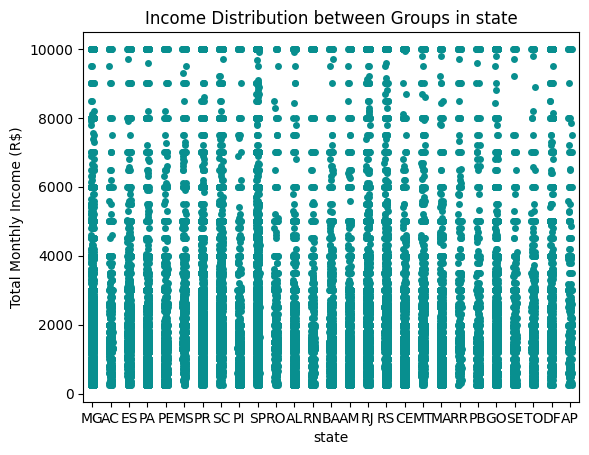

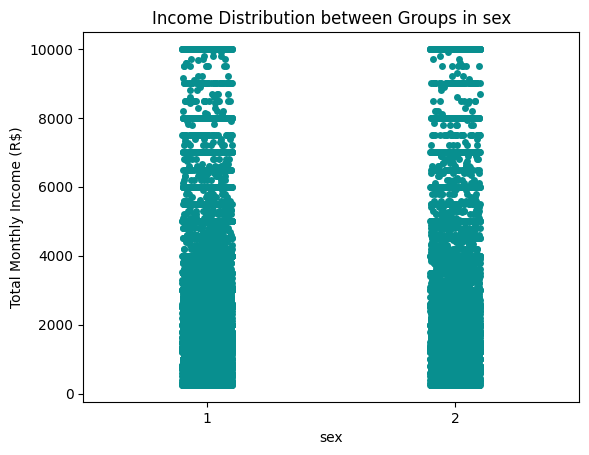

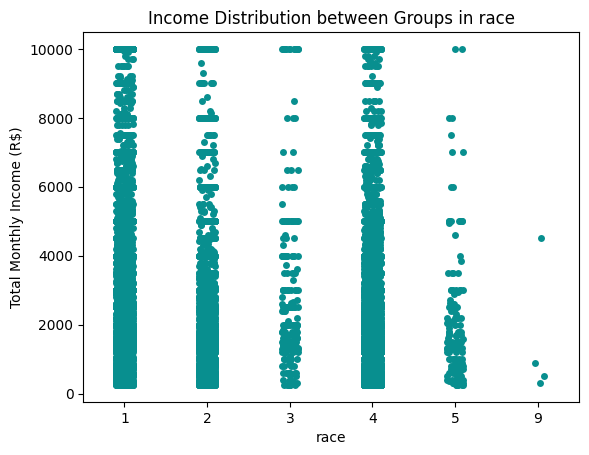

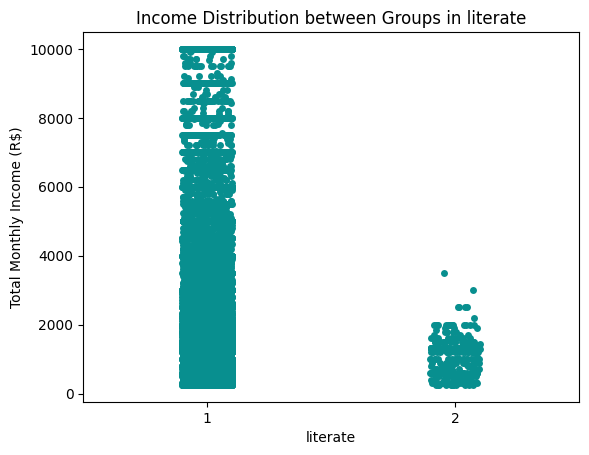

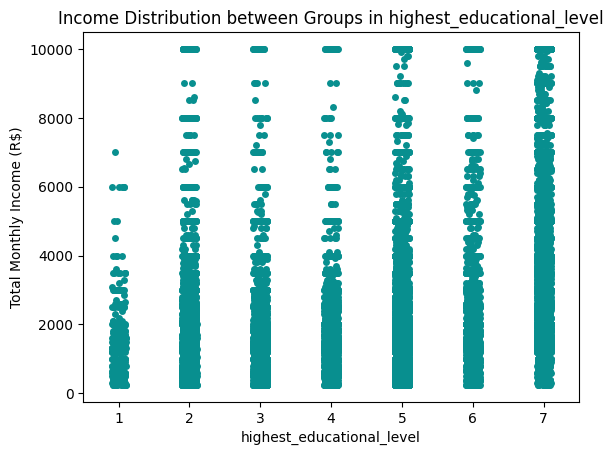

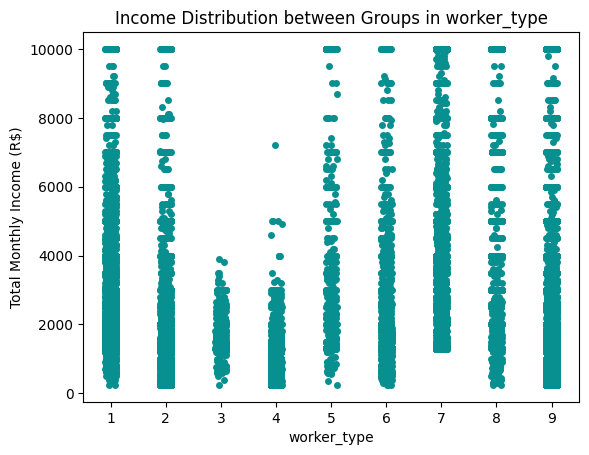

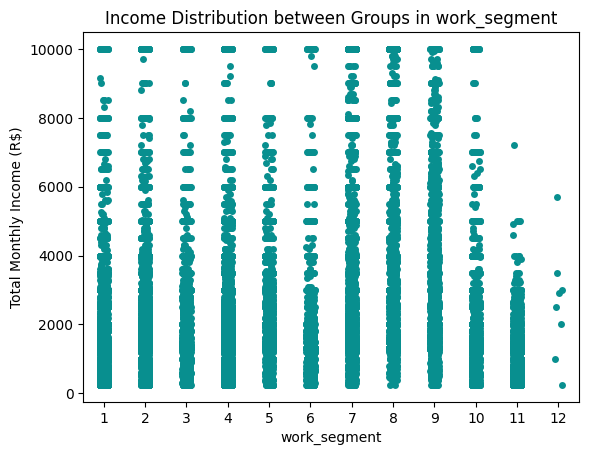

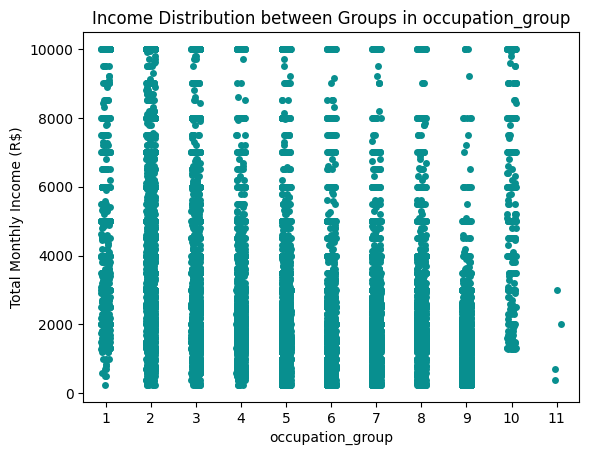

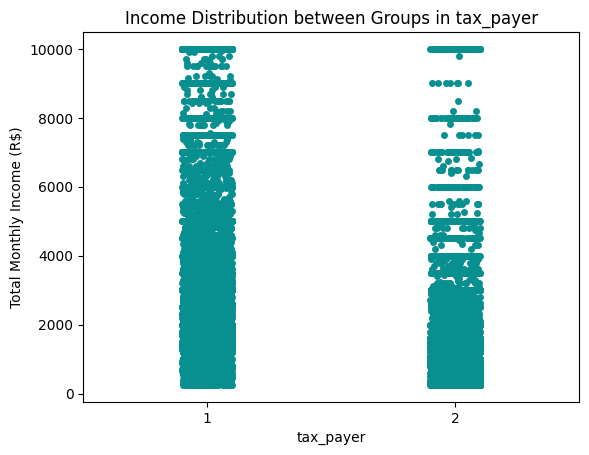

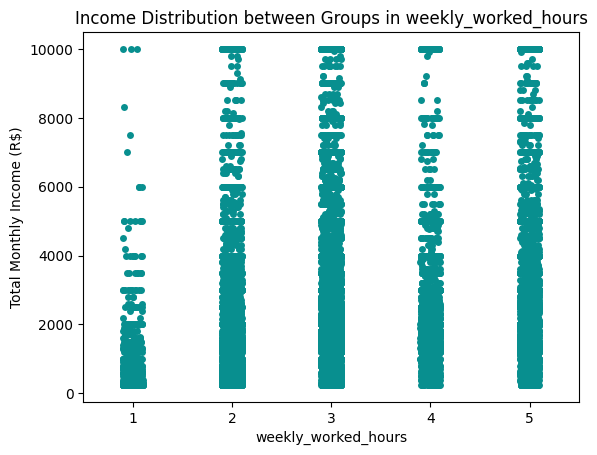

In [22]:
utils.plot_stripplot(
    df= df_sample,
    cat_columns = cat_columns,
    target = 'all_work_income',
    y_label = 'Total Monthly Income (R$)'
)

Some interesting findings from this inital plot:

1. In each column, **there are some unique groups** (for example: 1 in weekly_worked_hours, or 11 in occupation_group). They may represent a minority, but their income is clearly different from other groups for the same category.
2. **State has too many categories** and possibly no significant differences between states (may group them by region). Likewise I may group similar groups within each category.
3. Finally, groups differ by count (some are very rare) and income distribution 

In [41]:
# Defining new features for a possibly better division on the dataset

# states with possibly higher income, located in the southern regions of Brazil plus DF
df['state_v2'] = df['state'].apply(lambda x: 1 if x in ['MG', 'SP', 'RJ', 'RS', 'SC', 'PR', 'DF', 'ES'] else 2) 

# races with possibly higher income -> 1 (white) and 4 (mixed race)
df['race_v2'] = df['race'].apply(lambda x: 1 if x in [1, 4] else 2)

# educational levels with possibly higher income 0> 5, 6, 7
df['highest_educational_level_v2'] = df['highest_educational_level'].apply(lambda x: 1 if x < 5 else 2)

# worker types with possibly lower income -> 3,4 (domestic workers)
df['worker_type_v2'] = df['worker_type'].apply(lambda x: 1 if x in [3, 4] else 2)

# work segments with possibly lower income -> 7,8,9 (healthcare, technology, financial services, business, education)
df['work_segment_v2'] = df['work_segment'].apply(lambda x: 1 if x in [7, 8, 9] else 2)

Before I further proceed with feature engineering at this point of EDA, I would like to understand the **Mutual Information between the current features and the target.**

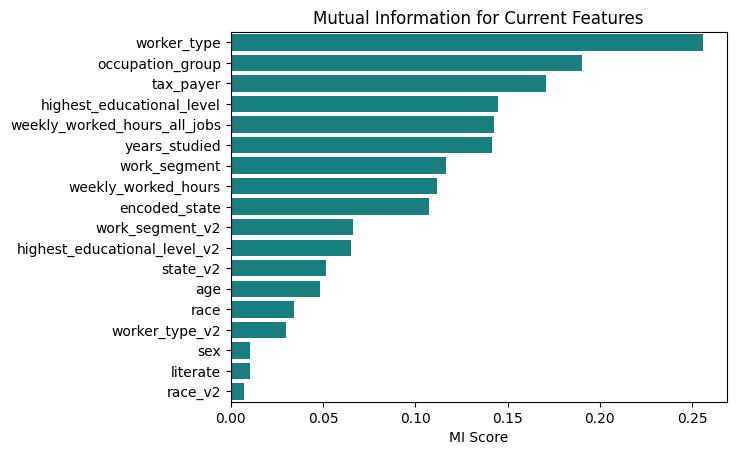

In [42]:
# Factorizing state, which is the only object type column in the dataset
df['encoded_state'] = OrdinalEncoder().fit_transform(df[['state']])

# Listing the features to test
features = [col for col in df.columns[1:] if 'income' not in col] #excludes state (first column) and all columns with 'income'

# Obtaining MI scores
mi = utils.mutual_information(
    X = df[features],
    y = df['all_work_income'],
    discrete_features = [False, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, True, True]
)

# Plotting MI scores
utils.show_barplot(
    cat = mi.index,
    values = mi,
    title = 'Mutual Information for Current Features',
    x_label = 'MI Score'
)


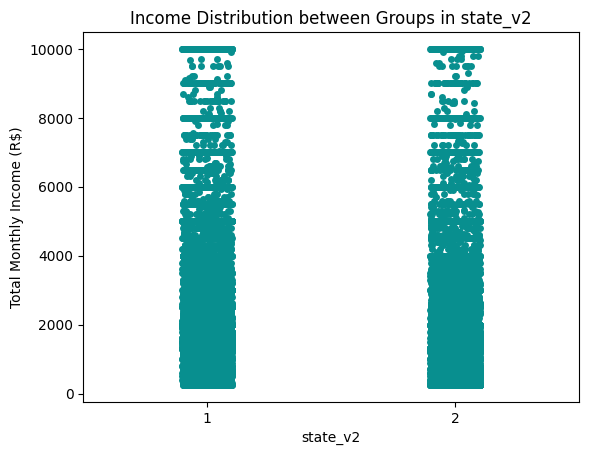

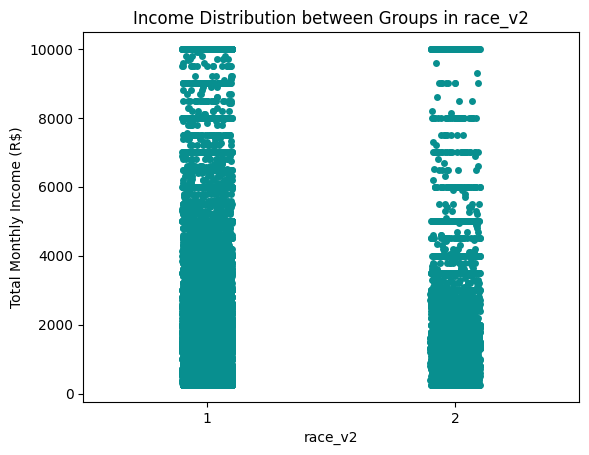

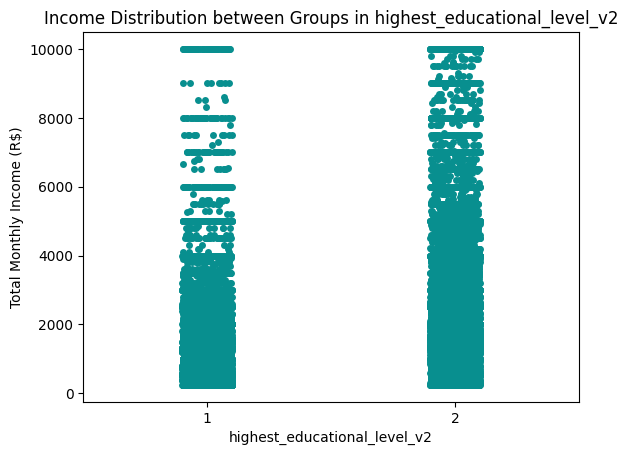

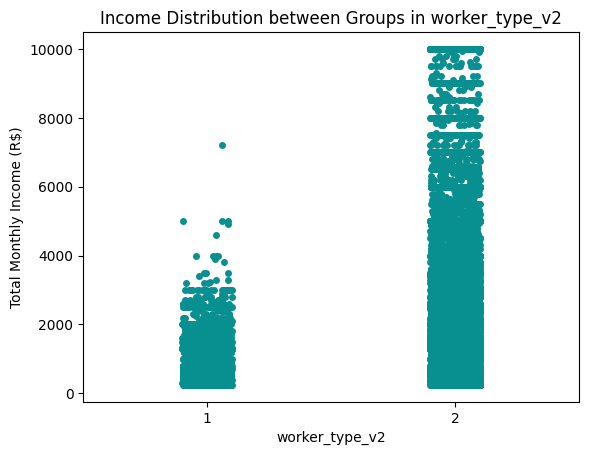

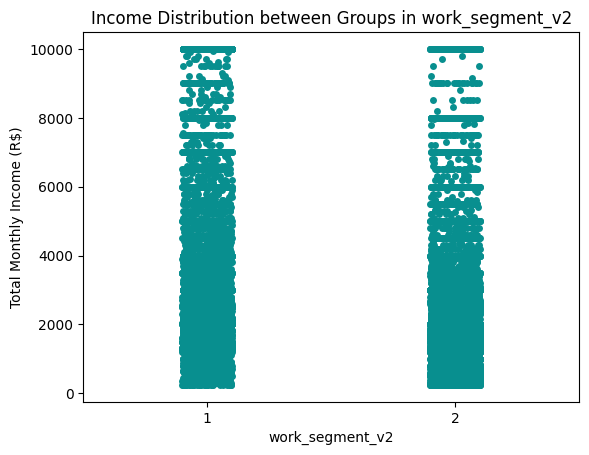

In [43]:
v2_features = [feature for feature in df.columns if '_v2' in feature]

test = df.sample(frac=0.05, random_state=0)

utils.plot_stripplot(
    df= test,
    cat_columns = v2_features,
    target = 'all_work_income',
    y_label = 'Total Monthly Income (R$)'
)